# Exploring Bike-Sharing Demand in Toronto, 2024
We want to understand the main demand patterns in the bike-sharing systems to build a suitable predictive system later.

In order to do that, we look at some graphs of bike-sharing usage for the Toronto Bike-Sharing system. Our central questions are:
- How does the input or output rates (the number of bikes taken in or out per amount of time) vary spatially over several times?
- What regularities do the in / out rates exhibit?
- Which stations are overfull / completely empty most often, i.e. are most problematic?
- How is the capacity of the system distributed over the city?

We use the ridership data published at Toronto's open data portal, which contains a collection of ride records for each month. Each ride record contains start and end times in minutes, start and end stations along with their id, the precise duration in seconds and several other information about the membership or the type of bike.

However, we do not have any information about historic capacities or bike numbers at time points, so we need to estimate when stations are at their maximum demand or not.
Additionally, the ridership data does not include information about bikes that are added or removed from stations for repair or repositioning purposes.


In [31]:
# !pip install numpy pandas matplotlib folium

# download the zip file
download_data = False
if download_data:
    zip_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/7e876c24-177c-4605-9cef-e50dd74c617f/resource/9a9a0163-8114-447c-bf66-790b1a92da51/download/bikeshare-ridership-2024.zip"
    
    !wget $zip_url -O ../data/bikeshare-ridership-2024.zip
    
    # unzip the file
    !unzip -o ../data/bikeshare-ridership-2024.zip -d ../data/bikeshare-ridership-2024 


import analysis as an
import pandas as pd

# If the data is not processed yet, process it and save it
# The preprocessing takes some time, so the processed data is stored in a pickle file

process_data = True
if process_data:
    ridership_table = pd.read_csv("../data/bikeshare-ridership-2024/Bike share ridership 2024-05.csv", encoding='cp1252')
    data = an.BikeShareData("2024-5")
    data.process_data_and_save(ridership_table)

Loaded 994 stations
Preprocessing ridership table
Number of rows with NaN End Station Id: 0


In [ ]:

import analysis as an
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import folium

data = an.BikeShareData.load_from_pickle(name = '2024-5')

avg_lat = np.mean(data.stations['lat'])
avg_lon = np.mean(data.stations['lon'])

## One Station
We first look at a plot of the cumulative number of bikes that should be at a station for one station over one month. We choose the bike station `St. George / Hoskin Ave` right at the University of Toronto here. We group the number of bikes coming in each minute (given by the end minute of each trip) and those that are taken out (given by the start minute of each trip) and then we take the cumulative sum of `inbikes` minus `outbikes`.

Notably, we see, that at this station, it seems that the number of bikes decreases over the course of time. This is explained by the fact that the ridership data only contains rides, but not repairs or repositioning of bikes, or errors of the logging system leading to excluded rides.
We can, however, clearly observe daily patterns over the month.
The larger spikes appear together in groups of 5 for each weekday, where the university is highly frequented, and are much smaller on the two following days. Usually, students use the bike to travel to the university in the morning, taking it back in the evening, thus we notice the peaks during the day.

[Text(0.5, 0, 'time (minutes)'),
 Text(0, 0.5, 'number of bikes'),
 Text(0.5, 1.0, 'Bikes at 7066, Willcocks St / St. George St, Cap: 15')]

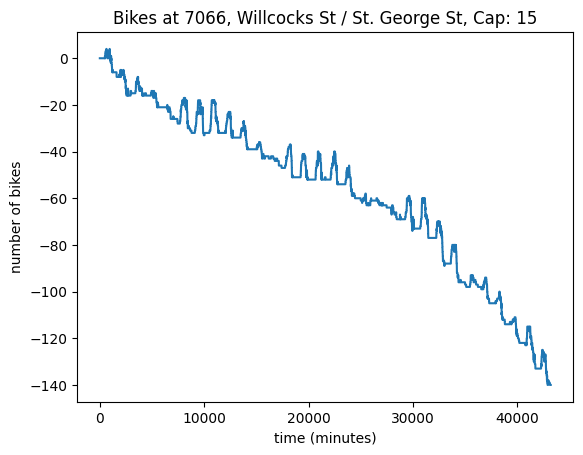

In [4]:
station = 7066 - 7000 # St. George St / Hoskin Ave
N_bikes = np.cumsum(data.in_bikes[station, :] - data.out_bikes[station, :])
plt.plot(N_bikes[0 : 24 * 60 * 30])
plt.gca().set(xlabel='time (minutes)', ylabel='number of bikes', title=f'Bikes at {7000 + station}, {data.stations.loc[station, 'name']}, Cap: {data.stations.loc[station, 'capacity']}', )

Now, we want to analyze demand patterns over the day, week and month. Our main goal here is to analyze the spatial properties of demand patterns over Toronto, thus we use the python library `folium` to visualize the distributions over the map.

## General In / Out Rate Calculation
Given the number of bikes returned and the number of bikes taken out at each minute, there is not a unique way to obtain a sensible continuous input / output rate.
We use a gaussian moving average here with a standard deviation of $60$ minutes because it produces a sensibly localized rate measure, that is smooth but still fine enough to distinguish hourly demand patterns.

In [19]:
data.stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_id           994 non-null    int64  
 1   name                 994 non-null    object 
 2   lat                  851 non-null    float64
 3   lon                  851 non-null    float64
 4   capacity             994 non-null    int64  
 5   altitude             445 non-null    float64
 6   is_charging_station  851 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.5+ KB


In [21]:
# Out Rates in the morning over toronto | Out Rates at noon | Out Rates in the evening
# (2) In Rates in the morning over toronto | In Rates at noon | In Rates in the evening
morning = 7 * 60
noon = 13 * 60
evening = 19 * 60
night = 1 * 60

# visualize the out rates in a map on folium for a specific time
time = morning
out_rates = data.out_bikes[:, time]

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11)

for station_idx in range(len(data.stations)):
    if np.isnan(data.stations.loc[station_idx, 'lat']):
        continue
    col = 'red' if data.stations.loc[station_idx, 'is_charging_station'] else 'blue'
    
    folium.CircleMarker(
        location=[data.stations.loc[station_idx, 'lat'], data.stations.loc[station_idx, 'lon']],
        radius=2,
        color=col,
        fill=True,
        fill_opacity=0.6,
        popup=f"Station {station_idx}, Out Rate: {out_rates[station_idx]}",
    ).add_to(m)



# opt: average over all days
m

In [6]:
from branca.colormap import linear
# animate the in rates over the day. Use the in rate at the beginning of each hour

# average the in_rates over all days
num_days = data.in_rates.shape[1] // (24 * 60)

in_rates_reshaped = np.reshape(data.in_rates[:, 0:num_days * 24 * 60], (len(data.stations), -1, 24 * 60))
in_rates_avg = np.mean(in_rates_reshaped, axis = 1)

stations = data.stations

def create_geojson_features(data, colormap, Δhours = 1):
    features = []
    # take the lons and lats of the stations
    lats = stations['lat']
    lons = stations['lon']
    max_data = np.max(data, axis = 1)

    # for _, row in df.iterrows():
    initial_date = pd.to_datetime('1980-01-01 00:00:00')
    for Δhour in np.arange(0, 24, Δhours):
        date = initial_date + pd.Timedelta(hours= Δhour)

        for station_idx in range(len(lats)):
            if np.isnan(lats[station_idx]) or max_data[station_idx] == 0:
                continue

            idx_hour = np.round(Δhour * 60).astype(int)
            ratio_to_max = data[station_idx, idx_hour] / max_data[station_idx]
            radius = int(2 * ratio_to_max) + 1
            color = colormap(ratio_to_max)                        

            feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates': [lons[station_idx], lats[station_idx]] # note: (!!!) : lon, lat order, but for positions: lat, lon
            },
            'properties': {
                'time': str(pd.to_datetime(date)), # str(pd.to_datetime(row['fake_date'])),
                'style': {'color': ''}, 
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': color,
                    "weight" :0 ,
                    'fillOpacity': 0.7,
                    #'stroke': 'true',
                    'radius': radius # row['average_res'] -5
                }
                }
            }
            features.append(feature)
    return features

colormap = linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'In-Rate / Max In-Rate at Station'

features = create_geojson_features(data = in_rates_avg, colormap = colormap, Δhours = 0.1) # note that the decimal digits are converted literally to minutes, not relative to the hour ,i.e. .25 is 25 minutes (!)

from folium.plugins import TimestampedGeoJson

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11,prefer_canvas=True)
TimestampedGeoJson(features,
                   period = 'PT10M', # time that each marker stays (PT xxx M : minutes)
                   duration = 'PT10M', # number of minutes a marker stays
                  transition_time = 200,
                   loop=True,
                  auto_play = True,
                  date_options=f"HH:mm",
                  ).add_to(m)
#title_html = '''
#                             <h3 align="center" style="font-size:20px"><b>Average In Rates Over the Day</b></h3>
#'''
#m.get_root().html.add_child(folium.Element(title_html))

colormap.add_to(m)
m.save('../documents/midterm_article/figs/in_rates_over_day.html')
#m

In [17]:
# the same for the out rates
out_rates_reshaped = np.reshape(data.out_rates[:, 0:num_days * 24 * 60], (len(data.stations), -1, 24 * 60))
out_rates_avg = np.mean(out_rates_reshaped, axis = 1)

colormap = linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'Out-Rate / Max Out-Rate at Station'

features = create_geojson_features(data = out_rates_avg, colormap=colormap, Δhours = 0.1)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11,prefer_canvas=True)
colormap.add_to(m)
TimestampedGeoJson(features,
                   period = 'PT10M', # 1 hour per frame
                   duration = 'PT10M', # every marker stays for one hour
                  transition_time = 200,
                   loop=True,
                  auto_play = True,
                  date_options=f"HH:mm",
                  ).add_to(m)
m.save('../documents/midterm_article/figs/out_rates_over_day.html')

## Average In Rates over the Day

To gain insights about the general traffic over the day, we visualize an animation of the average bike in rates over each day of the month. That is, we for each hour, we average over each day of the month and display circles proportional to this rate relative to the maximum rate at the station.
This is a measure of how many people at some time are reaching a specific destination in the city by bike.

We generally see large spikes of intaken bikes in downtown toronto around 7-10, then another one at 15-16 and reaching a max at 19-20, decreasing over the night.
We can also see some points lighting up in the periphery of the city at night, likely people getting home when the frequency of busses and other public transport is lower.


In [13]:
# Out Rates on {Mon, Tu, Wed, Th, Fri, Sat, Sun} ; opt: average over month
# only take 28 days here to have full weeks
in_rates_reshaped = np.reshape(data.in_rates[:, 0:28 * 24 * 60], (len(data.stations), -1, 24 * 60))
in_rates_avg = np.mean(in_rates_reshaped, axis = 2) # average each day

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
in_rates_avgs = np.zeros((len(data.stations), 7))
for day in range(7):
    in_rates_avgs[:, day] = np.mean(in_rates_avg[:, day::7], axis = 1)

def create_geojson2(data, colormap):
    features = []
    # take the lons and lats of the stations
    lats = stations['lat']
    lons = stations['lon']
    max_data = np.max(data, axis=1)

    initial_date = pd.to_datetime('2024-05-01 00:00:00')
    for day in range(7):
        date = initial_date + pd.Timedelta(days=day)
        for station_idx in range(len(lats)):
            if np.isnan(lats[station_idx]) or max_data[station_idx] == 0:
                continue
            ratio_to_max = data[station_idx, day] / max_data[station_idx]
            radius = int(3 * ratio_to_max) + 1
            color = colormap(ratio_to_max)

            feature = {
                'type': 'Feature',
                'geometry': {
                    'type': 'Point',
                    'coordinates': [lons[station_idx], lats[station_idx]]  # note: lon, lat order
                },
                'properties': {
                    'time': str(date),
                    'style': {'color': ''},
                    'icon': 'circle',
                    'iconstyle': {
                        'fillColor': color,
                        "weight": 0,
                        'fillOpacity': 0.7,
                        'radius': radius
                    }
                }
            }
            features.append(feature)
    return features

colormap = linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'In-Rate / Max In-Rate at Station'

features = create_geojson2(data = in_rates_avgs, colormap = colormap)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11,prefer_canvas=True)

colormap.add_to(m)

TimestampedGeoJson(features,
                   period = 'P1D', # 1 day per frame
                   duration = 'P1D', # every marker stays for one day
                  transition_time = 1000,
                   loop=True,
                   auto_play = True,
                date_options="dddd",
                  ).add_to(m)
m.save('../documents/midterm_article/figs/in_rates_over_week.html')
m

# Capacity Distribution over the City

In [ ]:
# plot the capacities as Clustered Markers
from folium.plugins import MarkerCluster

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in data.stations.iterrows():
    if np.isnan(row['lat']):
        continue
    folium.Marker(location=[row['lat'], row['lon']], popup=f"Station {idx}, {row['name']}, Cap: {row['capacity']}").add_to(marker_cluster)
    
m

In [15]:
# plot the connectivity of the stations induced by the trips
# i.e. 
# we first load the dataset
# group by start and end station
# count the number of rides
# remove connections with less than min_rides rides

file = '../data/bikeshare-ridership-2024/Bike share ridership 2024-05.csv'

ridership_table = pd.read_csv(file, encoding='cp1252')
ridership_table = an.preprocess_ridership_table(ridership_table)
ridership_table = ridership_table[['Start Station Id', 'End Station Id', 'Trip  Duration', 'Bike Id']]

# group by start and end station
connections = ridership_table.groupby(['Start Station Id', 'End Station Id']).count()

min_rides = 10
connections['N'] = connections['Bike Id']
connections = connections[connections['N'] > min_rides]

print(f"Number of Connections: {len(connections)}")

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11)

for idx, row in data.stations.iterrows():
    if np.isnan(row['lat']):
        continue
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.9,
        popup=f"Station {idx}, {row['name']}, Cap: {row['capacity']}"
    ).add_to(m)

# create a colormap like before, for the connections
from branca.colormap import linear

colormap = linear.YlOrRd_09.scale(min_rides, 100)
colormap.caption = 'Number of Trips'
colormap.add_to(m)

for idx, row in connections.iterrows():
    start_station = idx[0] - 7000
    end_station = idx[1] - 7000

    start_station = data.stations.loc[start_station]
    end_station = data.stations.loc[end_station]
    if np.isnan(start_station['lat']) or np.isnan(end_station['lat']):
        continue

    color = colormap(row['N'])

    folium.PolyLine([(start_station['lat'], start_station['lon']), (end_station['lat'], end_station['lon'])], color=color, weight=1, opacity=0.5).add_to(m)

m.save('../documents/midterm_article/figs/station_connections.html')
#m


Preprocessing ridership table
Number of rows with NaN End Station Id: 0
Number of Connections: 14465


In [14]:
# save the map
m.save('../documents/midterm_article/figs/station_connections.html')